In [7]:
import pandas as pd
import os
from tqdm import tqdm
import csv
import re
from collections import Counter

In [8]:
iemocap_dataset_path = r'/media/cv/Extreme Pro/IEMOCAP/IEMOCAP_full_release/'
sessions = [os.path.join(iemocap_dataset_path, folder, 'dialog')  for folder in os.listdir(iemocap_dataset_path) if folder[:7] == "Session"]
facial_landmarks = [os.path.join(session, 'MOCAP_rotated', file) for session in sessions \
    for file in os.listdir(os.path.join(session, 'MOCAP_rotated')) if file[0] != '.']
labels = [os.path.join(session, 'EmoEvaluation', file) for session in sessions \
    for file in os.listdir(os.path.join(session, 'EmoEvaluation')) if file[0] != '.' and file[-3:] == 'txt']


In [9]:
len(labels), len(facial_landmarks)

(151, 150)

In [10]:
id2joints = {
    1: 'CH1', 2: 'CH2', 3: 'CH3', 4: 'FH1', 5: 'FH2', 6: 'FH3', 7: 'LC1', 8: 'LC2', 9: 'LC3', 10: 'LC4', 
    11: 'LC5', 12: 'LC6', 13: 'LC7', 14: 'LC8', 15: 'RC1', 16: 'RC2', 17: 'RC3', 18: 'RC4', 19: 'RC5', 20: 'RC6',
    21: 'RC7', 22: 'RC8', 23: 'LLID', 24: 'RLID', 25: 'MH', 26: 'MNOSE', 27: 'LNSTRL', 28: 'TNOSE', 29: 'RNSTRL', 30: 'LBM0', 
    31: 'LBM1', 32: 'LBM2', 33: 'LBM3', 34: 'RBM0', 35: 'RBM1', 36: 'RBM2', 37: 'RBM3', 38: 'LBRO1', 39: 'LBRO2', 40: 'LBRO3', 
    41: 'LBRO4', 42: 'RBRO1', 43: 'RBRO2', 44: 'RBRO3', 45: 'RBRO4', 46: 'Mou1', 47: 'Mou2', 48: 'Mou3', 49: 'Mou4', 50: 'Mou5', 
    51: 'Mou6', 52: 'Mou7', 53: 'Mou8', 54: 'LHD', 55: 'RHD'
}

joints2ids = {v:k for k, v in id2joints.items()}



In [11]:
facial_landmarks = sorted(facial_landmarks)
labels = sorted(labels)

In [12]:
def parse_landmarks(source_file, dest_file):
    read_file = open(source_file, 'r')
    write_file = open(dest_file, 'w')

    header = []
    
    for i, line in enumerate(read_file.readlines()):
        if i == 0:
            header.extend(line.split()[:2])
            continue
        elif i == 1:
            header.extend(line.split())
            header = ','.join(header) + '\n'
            write_file.write(header)
            continue
            
        csv_line = ','.join(line.split()) + '\n'
        write_file.write(csv_line)

    read_file.close()
    write_file.close()
    return

    
def parse_labels(source_file, dest_file):
    data = []
    # Regular expressions to match the start-end time and emotions
    
    filename = source_file.split('/')[-1]
    if 'F' in filename:
        motion = 'F'
    elif 'M' in filename:
        motion = 'M'
    else:
        raise ValueError("Sanity Check: No infor about the gender in the filename")
    
    time_pattern = r"\[(\d+\.\d+) - (\d+\.\d+)\]"
    emotion_pattern = r"([A-Za-z]+);"
    # Splitting the file content into lines
    with open(source_file, 'r') as f:
        lines = f.readlines()

    emotions = []
    for line in lines:
        # Match the time and emotion using regex
        time_match = re.search(time_pattern, line)
        emotion_matches = re.findall(emotion_pattern, line)
        
        if time_match:
            start_time = float(time_match.group(1))
            end_time = float(time_match.group(2))
            if len(emotions) > 0:
                emo = Counter(emotions)
                emo = max(emo, key=emo.get)
                data.append([prev_start_time, prev_end_time, emo])
                emotions = []
            prev_start_time = start_time
            prev_end_time = end_time
        if emotion_matches:
            emotions.extend(emotion_matches)
            
    # Writing data to CSV
    with open(dest_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(['Start Time', 'End Time', 'Emotion'])
        # Write data rows
        writer.writerows(data)
        
    return 
    

In [14]:
for source_file in tqdm(facial_landmarks):
    file_name = source_file.split('/')[-1].replace('.txt', '.csv')
    dest_path = f'./iemocap_processed/landmarks/{file_name}'
    parse_landmarks(source_file, dest_path)    


 51%|█████     | 76/150 [01:49<01:46,  1.44s/it]


KeyboardInterrupt: 

In [138]:
for source_file in tqdm(labels):
    file_name = source_file.split('/')[-1].replace('.txt', '.csv')
    if 'b' in file_name:
        continue
    dest_path = f'./iemocap_processed/labels/{file_name}'
    parse_labels(source_file, dest_path)    


100%|██████████| 151/151 [00:00<00:00, 288.78it/s]


In [169]:
FPS = 120

def merge_landmarks_labels(source_csv, labels_csv, dest_csv, FPS=120):

    _landmarks = pd.read_csv(source_csv)
    _labels = pd.read_csv(labels_csv)

    _labels['start_frame'] = (_labels['Start Time'] * FPS).astype(int)
    _labels['end_frame'] = (_labels['End Time'] * FPS).astype(int)
    _labels['diff'] = _labels['start_frame'].diff()
    _labels = _labels.fillna(0)
    
    emotions_f = ['NA'] * _landmarks.shape[0]
    emotions_m = ['NA'] * _landmarks.shape[0]
    
    female = True
    for i, row in _labels.iterrows():
        start_frame = row['start_frame']
        end_frame = row['end_frame']
        emotion = row['Emotion']
        diff = row['diff']
        if diff < 0:
            female = False
        for i in range(start_frame, end_frame + 1):
            if i >= _labels.shape[0]:
                continue
            if female:
                emotions_f[i] = emotion
            else:
                emotions_m[i] = emotion
        
    _landmarks['labels_male'] = emotions_m
    _landmarks['label_feamle'] = emotions_f
    
    _landmarks.to_csv(dest_csv)
    return

In [15]:
label_folder_path = './iemocap_processed/labels'
landmarks_folder_path = './iemocap_processed/landmarks'
merged_folder_path = './iemocap_processed/merged'

label_files = sorted(
    [os.path.join(label_folder_path, file) for file in (os.listdir(label_folder_path))]
)
landmark_files = sorted(
    [os.path.join(landmarks_folder_path, file) for file in (os.listdir(landmarks_folder_path))]
)

count = 0

for landmark_file, label_file in zip(landmark_files, label_files):
    count += 1
    if count < 123:
        continue
    filename = landmark_file.split('/')[-1]
    print(filename, filename == label_file.split('/')[-1], count)
    save_path = f'./iemocap_processed/merged/{filename}'
    
    merge_landmarks_labels(landmark_file, label_file, save_path, FPS=120)

Ses05F_impro03.csv True 123


NameError: name 'merge_landmarks_labels' is not defined

In [16]:
merged_files = sorted(
    [os.path.join(merged_folder_path, file) for file in (os.listdir(merged_folder_path))]
)

In [ ]:
import warnings

def load_df(path):
    filename = path.split('/')[-1]
    df = pd.read_csv(path, index_col=['Frame#'])
    df['label'] = df['labels_male'] if filename[5] == 'M' else df['label_feamle']
    df.dropna(inplace=True)
    df.drop('Unnamed: 0', axis=1, inplace=True)    
    df.drop(columns=['labels_male', 'label_feamle'], inplace=True)
    return df


def build_dataset_from_files(files: list, sampling_frac=0.5):
    data = []
    for i, file in enumerate(files):
        filename = file.split('/')[-1]
        df = load_df(file)
        with warnings.simplefilter("ignore"):
            df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=sampling_frac))
        df['session'] = filename
        data.append(df)
    data = pd.concat(data)
    return data

def build_dataset(files: list, sampling_frac: float=0.5):
    if sampling_frac > 0.9 and sampling_frac< 0.1:
        raise ValueError("Invalid sampling fraction, should be lwoer than 0.9 and greater than 0.1")
    train_files = []
    test_files = []
    
    for file in files:
        if 'Ses05' not in file:
            train_files.append(file)
        else:
            test_files.append(file)
    print(len(train_files), len(test_files))       
    train = build_dataset_from_files(train_files, sampling_frac)
    test = build_dataset_from_files(test_files, sampling_frac)
    
    return (train, test)

train_data, test_data = build_dataset(merged_files)

In [18]:
len(train_data), len(test_data)

(372143, 123399)

In [19]:
train_data.to_pickle('./iemocap_processed/pickled/train.pkl')

In [20]:
test_data.to_pickle('./iemocap_processed/pickled/test.pkl')

# Training

In [36]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


lower_landmarks = [
    'RC1', 'RC2', 'RC4', 'LC1', 'LC2', 'LC4', 'CH1', 'CH2', 'CH3', 'Mou1', 'Mou2', 'Mou3', 'Mou4', 'Mou5',
    'Mou6', 'Mou7', 'Mou8', 'RNSTRL', 'LNSTRL', 'TNOSE']
all_landmarks = [
    'CH1', 'CH2', 'CH3', 'FH1', 'FH2', 'FH3', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8', 
    'RC1', 'RC2', 'RC3', 'RC4', 'RC5', 'RC6', 'RC7', 'RC8', 'LLID', 'RLID', 'MH', 'MNOSE', 'LNSTRL', 
    'TNOSE', 'RNSTRL', 'LBM0', 'LBM1', 'LBM2', 'LBM3', 'RBM0', 'RBM1', 'RBM2', 'RBM3', 'LBRO1', 'LBRO2', 
    'LBRO3', 'LBRO4', 'RBRO1', 'RBRO2', 'RBRO3', 'RBRO4', 'Mou1', 'Mou2', 'Mou3', 'Mou4', 'Mou5', 'Mou6', 
    'Mou7', 'Mou8', 'LHD', 'RHD']

class IEMOCAPLandmark(nn.Module):
    def __init__(self, path):
        self.df = pd.read_pickle(path)
        self.df = self.df.loc[ self.df['label'] != 'Other']
        
        self.id2joints = {
            1: 'CH1', 2: 'CH2', 3: 'CH3', 4: 'FH1', 5: 'FH2', 6: 'FH3', 7: 'LC1', 8: 'LC2', 9: 'LC3', 10: 'LC4', 
            11: 'LC5', 12: 'LC6', 13: 'LC7', 14: 'LC8', 15: 'RC1', 16: 'RC2', 17: 'RC3', 18: 'RC4', 19: 'RC5', 20: 'RC6',
            21: 'RC7', 22: 'RC8', 23: 'LLID', 24: 'RLID', 25: 'MH', 26: 'MNOSE', 27: 'LNSTRL', 28: 'TNOSE', 29: 'RNSTRL', 30: 'LBM0', 
            31: 'LBM1', 32: 'LBM2', 33: 'LBM3', 34: 'RBM0', 35: 'RBM1', 36: 'RBM2', 37: 'RBM3', 38: 'LBRO1', 39: 'LBRO2', 40: 'LBRO3', 
            41: 'LBRO4', 42: 'RBRO1', 43: 'RBRO2', 44: 'RBRO3', 45: 'RBRO4', 46: 'Mou1', 47: 'Mou2', 48: 'Mou3', 49: 'Mou4', 50: 'Mou5', 
            51: 'Mou6', 52: 'Mou7', 53: 'Mou8', 54: 'LHD', 55: 'RHD'
        }
        self.joints2ids = {v:k for k, v in self.id2joints.items()}

        self.label2id = {
            'Frustration':0,
            'Anger':1,
            'Excited':2,
            'Neutral':3,
            'Happiness':4,
            'Sadness':5,
            'Fear':6,
            'Surprise':7,
        }

        self.id2label = {
            0: 'Frustration',
            1: 'Anger',
            2: 'Excited',
            3: 'Neutral',
            4: 'Happiness',
            5: 'Sadness',
            6: 'Fear',
            7: 'Surprise',
        }

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = torch.tensor(self.df.iloc[index]['X01': 'Z61'].astype(float).to_numpy(), dtype=torch.float32)
        label = torch.tensor(self.label2id[self.df.iloc[index]['label']])
        return (row, label)
        

In [37]:
class MLPLandmark(nn.Module):
    def __init__(self, inp_dim: int, out_dim: int, layers: list):
        super().__init__()
        
        self.inp_dim = inp_dim
        
        self.mlp = nn.ModuleList()
        
        self.mlp.append(nn.Linear(self.inp_dim, layers[0]))
        
        for i in range(1, len(layers)):
            self.mlp.append(
                nn.Sequential(
                    nn.Linear(layers[i-1], layers[i]),
                    nn.ReLU(),
                    nn.LayerNorm(layers[i])
                )
            )
        
        self.mlp.append(nn.Linear(layers[-1], out_dim))
        
    def forward(self, x: torch.Tensor):
        x = x.view(x.shape[0], self.inp_dim)
        
        for layer in self.mlp:
            x = layer(x)
        
        return x

In [38]:

test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]


def train(weights_save_path):
    
    '''
    Updates the global variables need to check that
    '''
    
    eval_loss = 0.0
    eval_acc = 0.0
    max_eval_acc = -1
    
    for epoch in range(epochs):
        model.train()
        
        for i, batch in enumerate(trainloader):
            # zero gradients
            optimizer.zero_grad()
            
            landmarks, labels = batch
            landmarks: torch.Tensor =landmarks.to(device)
            labels: torch.Tensor = labels.to(device)
            
            logits = model(landmarks)
            loss = criterion(logits, labels)
            
            
            #back_prop
            loss.backward()
            optimizer.step()
            
            if i % 500 == 0:
                print(f"Epoch: {epoch} | iteration {i}/{len(trainloader)} | Loss: {loss.item():.4f} | Last Eval Loss: {eval_loss:.4f}| Last Eval Accuracy: {eval_acc:.4f}")
            
            # track stats
            train_loss.append(loss.item())
            train_step.append(train_step[-1] + 1)
        
        # evaluate the model
        eval_loss, eval_acc = test()
        
        # track evaluation dataset stats
        test_acc.append(eval_acc)
        test_loss.append(eval_loss)
        
        # save the best model
        if eval_acc > max_eval_acc:
            torch.save(model.state_dict(), weights_save_path)
            max_eval_acc = eval_acc
        
    print("Evaluation Loss: ",  eval_loss, eval_acc)
    
    
@torch.no_grad()         
def test():
    preds_ = []
    labels_ = []
    eval_loss = []
    model.eval()
    for i, batch in enumerate(testloader):
        
        landmarks, labels = batch
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        
        logits = model(landmarks)
        
        preds = torch.argmax(logits, dim=1)
        preds_.extend((preds.cpu().tolist()))
        labels_.extend(labels.cpu().tolist())
        
        loss = criterion(logits, labels)
        
        eval_loss.append(loss.item())
    
    return (sum(eval_loss)/len(eval_loss), accuracy_score(preds_, labels_))

In [39]:
device='cuda:1'
epochs = 100
lr = 1e-3


model = MLPLandmark(inp_dim=165, out_dim=8, layers=[1024, 1024, 1024]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

BATCH_SIZE = 128

train_dataset = IEMOCAPLandmark('./iemocap_processed/pickled/train.pkl')
test_dataset = IEMOCAPLandmark('./iemocap_processed/pickled/test.pkl')

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [40]:
len(train_dataset), len(test_dataset)

(370956, 123198)

In [41]:
test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]

train('./model_weights/landmark_all_iemocap_emotion.pt')

Epoch: 0 | iteration 0/2899 | Loss: 2.2998 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 500/2899 | Loss: 1.5125 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 1000/2899 | Loss: 1.4522 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 1500/2899 | Loss: 1.3844 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 2000/2899 | Loss: 1.3300 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 2500/2899 | Loss: 1.2089 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 1 | iteration 0/2899 | Loss: 1.1895 | Last Eval Loss: 2.2434| Last Eval Accuracy: 0.2509
Epoch: 1 | iteration 500/2899 | Loss: 1.2666 | Last Eval Loss: 2.2434| Last Eval Accuracy: 0.2509
Epoch: 1 | iteration 1000/2899 | Loss: 1.3599 | Last Eval Loss: 2.2434| Last Eval Accuracy: 0.2509
Epoch: 1 | iteration 1500/2899 | Loss: 1.0393 | Last Eval Loss: 2.2434| Last Eval Accuracy: 0.2509
Epoch: 1 | iterati

Text(0, 0.5, 'Loss')

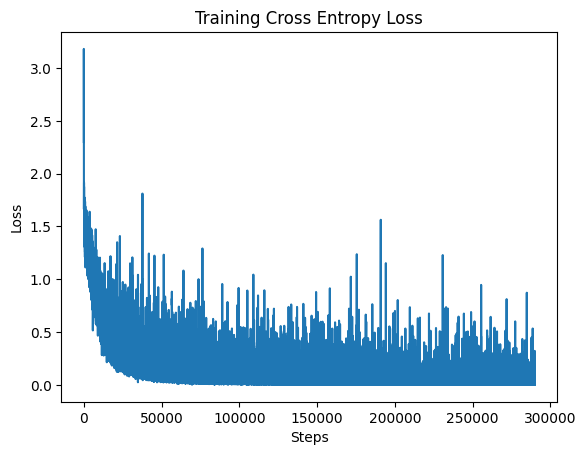

In [42]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(train_step[1:], train_loss[1:])
plt.title("Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy Score %')

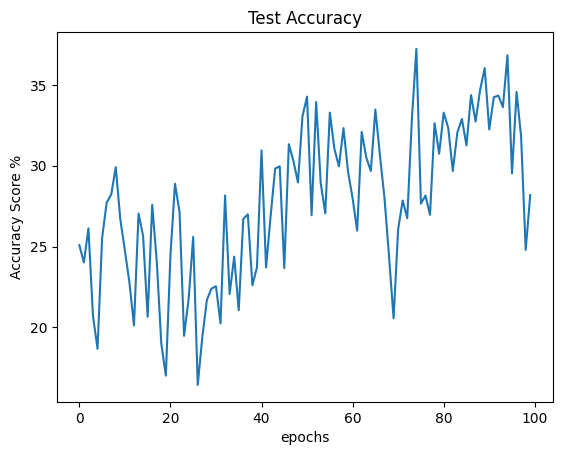

In [43]:
plt.plot(np.array(test_acc) * 100)
plt.title("Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy Score %")

In [44]:
class IEMOCAPLandmarkLower(nn.Module):
    def __init__(self, path):
        self.df = pd.read_pickle(path)
        self.df = self.df.loc[ self.df['label'] != 'Other']
        
        self.columns_to_extract = [
            'X15', 'Y15', 'Z15', 'X16', 'Y16', 'Z16', 'X18', 'Y18', 'Z18', 'X07',
            'Y07', 'Z07', 'X08', 'Y08', 'Z08', 'X10', 'Y10', 'Z10', 'X01', 'Y01',
            'Z01', 'X02', 'Y02', 'Z02', 'X03', 'Y03', 'Z03', 'X46', 'Y46', 'Z46',
            'X47', 'Y47', 'Z47', 'X48', 'Y48', 'Z48', 'X49', 'Y49', 'Z49', 'X50',
            'Y50', 'Z50', 'X51', 'Y51', 'Z51', 'X52', 'Y52', 'Z52', 'X53', 'Y53',
            'Z53', 'X29', 'Y29', 'Z29', 'X27', 'Y27', 'Z27', 'X28', 'Y28', 'Z28'
            ]
        
        self.label2id = {
            'Frustration':0,
            'Anger':1,
            'Excited':2,
            'Neutral':3,
            'Happiness':4,
            'Sadness':5,
            'Fear':6,
            'Surprise':7,
        }

        self.id2label = {
            0: 'Frustration',
            1: 'Anger',
            2: 'Excited',
            3: 'Neutral',
            4: 'Happiness',
            5: 'Sadness',
            6: 'Fear',
            7: 'Surprise',
        }

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = torch.tensor(self.df.iloc[index][self.columns_to_extract].astype(float).to_numpy(), dtype=torch.float32)
        label = torch.tensor(self.label2id[self.df.iloc[index]['label']])
        return (row, label)

In [45]:
device='cuda:1'
epochs = 100
lr = 1e-3


model = MLPLandmark(inp_dim=60, out_dim=8, layers=[1024, 1024, 1024]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

BATCH_SIZE = 128

train_dataset = IEMOCAPLandmarkLower('./iemocap_processed/pickled/train.pkl')
test_dataset = IEMOCAPLandmarkLower('./iemocap_processed/pickled/test.pkl')

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [46]:
test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]

train('./model_weights/landmark_lower_iemocap_emotion.pt')

Epoch: 0 | iteration 0/2899 | Loss: 2.1369 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 500/2899 | Loss: 1.4828 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 1000/2899 | Loss: 1.4206 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 1500/2899 | Loss: 1.3599 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 2000/2899 | Loss: 1.0994 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | iteration 2500/2899 | Loss: 1.1838 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 1 | iteration 0/2899 | Loss: 1.2847 | Last Eval Loss: 2.0715| Last Eval Accuracy: 0.4035
Epoch: 1 | iteration 500/2899 | Loss: 1.0796 | Last Eval Loss: 2.0715| Last Eval Accuracy: 0.4035
Epoch: 1 | iteration 1000/2899 | Loss: 1.1105 | Last Eval Loss: 2.0715| Last Eval Accuracy: 0.4035
Epoch: 1 | iteration 1500/2899 | Loss: 1.0984 | Last Eval Loss: 2.0715| Last Eval Accuracy: 0.4035
Epoch: 1 | iterati

Text(0, 0.5, 'Loss')

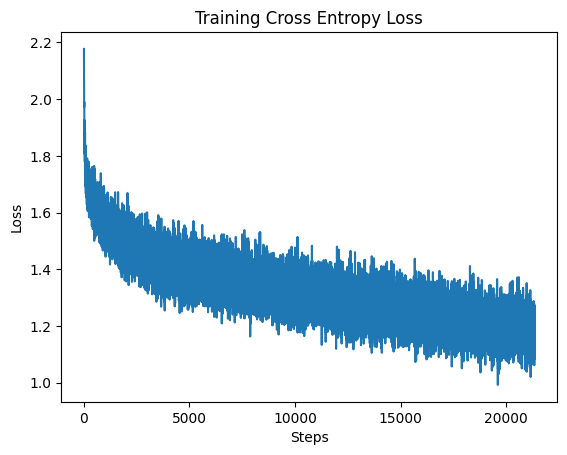

In [ ]:
plt.plot(train_step[1:], train_loss[1:])
plt.title("Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

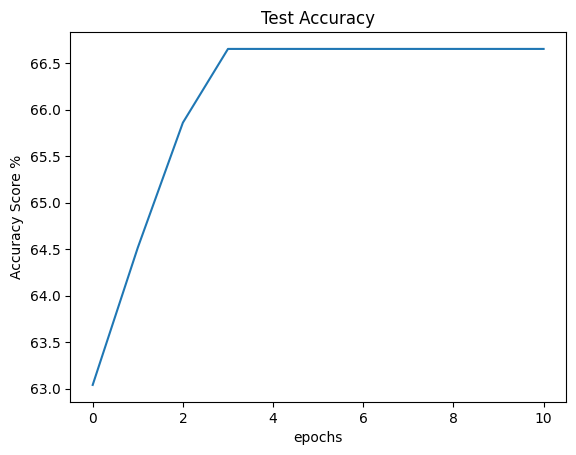

In [ ]:
plt.plot(np.array(test_acc) * 100)
plt.title("Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy Score %")
plt.show()